In [5]:
%load_ext autoreload
%autoreload 2

train_path = "../Datasets/JSRT_Padchest/Train"
test_path = "../Datasets/JSRT_Padchest/Test"
val_path = "../Datasets/JSRT_Padchest/Val" 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys 
sys.path.append('..')

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import time

In [8]:
from models.hybridDoubleSkip import Hybrid as DoubleSkip
from models.hybrid import Hybrid as Hybrid
from models.joint import Joint
from models.rasterize_finetune import Hybrid_Rasterize as Rasterize
from models.unet_joint import UNet_Joint
from models.unet import UNet
from models.hourglass import Hourglass
from models.hourglass_concat import Hourglass_Concat
from models.multi_task import Multi_Task


import os 
from torchvision import transforms
from utils.dataLoader_XR import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'Landmarks')
sdf_path = os.path.join(test_path, 'SDF')
mask_path = os.path.join(test_path, 'Masks')
test_dataset = LandmarksDataset(img_path=img_path,
                                mask_path=mask_path,
                                sdf_path = sdf_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )

device = 'cuda:0'
#device = 'cpu'

In [10]:
A, AD, D, U, E, ED = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 16
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5
config['n_classes'] = 3

In [11]:
HybridGNet_1 = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_1.load_state_dict(torch.load("../weights/JSRT_Padchest/HybridGNet/1/bestMSE.pt"))
HybridGNet_1.eval()
print('Model loaded')

HybridGNet_2 = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_2.load_state_dict(torch.load("../weights/JSRT_Padchest/HybridGNet/2/bestMSE.pt"))
HybridGNet_2.eval()
print('Model loaded')

HybridGNet_3 = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_3.load_state_dict(torch.load("../weights/JSRT_Padchest/HybridGNet/3/bestMSE.pt"))
HybridGNet_3.eval()
print('Model loaded')

Model loaded
Model loaded
Model loaded


In [13]:
config['l1'] = 6
config['l2'] = 5
config['latents'] = 64

HybridGNet_IGSC_1 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_IGSC_1.load_state_dict(torch.load("../weights/JSRT_Padchest/HybridGNet_IGSC/1/bestMSE.pt"))
HybridGNet_IGSC_1.eval()
print('Model loaded')

HybridGNet_IGSC_2 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_IGSC_2.load_state_dict(torch.load("../weights/JSRT_Padchest/HybridGNet_IGSC/2/bestMSE.pt"))
HybridGNet_IGSC_2.eval()
print('Model loaded')

HybridGNet_IGSC_3 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HybridGNet_IGSC_3.load_state_dict(torch.load("../weights/JSRT_Padchest/HybridGNet_IGSC/3/bestMSE.pt"))
HybridGNet_IGSC_3.eval()
print('Model loaded')

6-5
Model loaded
6-5
Model loaded
6-5
Model loaded


In [14]:
config['l1'] = 6
config['l2'] = 5
config['latents'] = 16

HCD_1 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HCD_1.load_state_dict(torch.load("../weights/JSRT_Padchest/HCD/1/bestMSE.pt"))
HCD_1.eval()
print('Model loaded')

HCD_2 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HCD_2.load_state_dict(torch.load("../weights/JSRT_Padchest/HCD/2/bestMSE.pt"))
HCD_2.eval()
print('Model loaded')

HCD_3 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
HCD_3.load_state_dict(torch.load("../weights/JSRT_Padchest/HCD/3/bestMSE.pt"))
HCD_3.eval()
print('Model loaded')

6-5
Model loaded
6-5
Model loaded
6-5
Model loaded


In [15]:
config['load'] = '../models/hybridgnet_weights/bestMSE_JSRT_Padchest.pt'
config['latents'] = 64

Rasterize_1 = Rasterize(config.copy(), D_t, U_t, A_t).to(device)
Rasterize_1.load_state_dict(torch.load("../weights/JSRT_Padchest/Rasterize/1/bestMSE.pt"))
Rasterize_1.eval()
print('Model loaded')

Rasterize_2 = Rasterize(config.copy(), D_t, U_t, A_t).to(device)
Rasterize_2.load_state_dict(torch.load("../weights/JSRT_Padchest/Rasterize/2/bestMSE.pt"))
Rasterize_2.eval()
print('Model loaded')

Rasterize_3 = Rasterize(config.copy(), D_t, U_t, A_t).to(device)
Rasterize_3.load_state_dict(torch.load("../weights/JSRT_Padchest/Rasterize/3/bestMSE.pt"))
Rasterize_3.eval()
print('Model loaded')

6-5
Model loaded
6-5
Model loaded
6-5
Model loaded


In [16]:
config['latents'] = 16
config['unet_weights'] = '../models/unet_weights/bestDice_JSRT_Padchest.pt'
config['rtn_all'] = False

Hourglass_1 = Hourglass(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_1.load_state_dict(torch.load("../weights/JSRT_Padchest/Hourglass/1/bestMSE.pt"))
Hourglass_1.eval()
print('Model loaded')

Hourglass_2 = Hourglass(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_2.load_state_dict(torch.load("../weights/JSRT_Padchest/Hourglass/2/bestMSE.pt"))
Hourglass_2.eval()
print('Model loaded')

Hourglass_3 = Hourglass(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_3.load_state_dict(torch.load("../weights/JSRT_Padchest/Hourglass/3/bestMSE.pt"))
Hourglass_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [17]:
config['latents'] = 16
config['unet_weights'] = '../models/unet_weights/bestDice_JSRT_Padchest.pt'
config['rtn_all'] = False

Hourglass_Concat_1 = Hourglass_Concat(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_Concat_1.load_state_dict(torch.load("../weights/JSRT_Padchest/Hourglass_Concat/1/bestMSE.pt"))
Hourglass_Concat_1.eval()
print('Model loaded')

Hourglass_Concat_2 = Hourglass_Concat(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_Concat_2.load_state_dict(torch.load("../weights/JSRT_Padchest/Hourglass_Concat/2/bestMSE.pt"))
Hourglass_Concat_2.eval()
print('Model loaded')

Hourglass_Concat_3 = Hourglass_Concat(config.copy(), D_t, U_t, A_t).to(device)
Hourglass_Concat_3.load_state_dict(torch.load("../weights/JSRT_Padchest/Hourglass_Concat/3/bestMSE.pt"))
Hourglass_Concat_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [18]:
Multi_Task_1 = Multi_Task(config.copy(), D_t, U_t, A_t).to(device)
Multi_Task_1.load_state_dict(torch.load("../weights/JSRT_Padchest/Multi_Task/1/bestMSE.pt"))
Multi_Task_1.eval()
print('Model loaded')

Multi_Task_2 = Multi_Task(config.copy(), D_t, U_t, A_t).to(device)
Multi_Task_2.load_state_dict(torch.load("../weights/JSRT_Padchest/Multi_Task/2/bestMSE.pt"))
Multi_Task_2.eval()
print('Model loaded')

Multi_Task_3 = Multi_Task(config.copy(), D_t, U_t, A_t).to(device)
Multi_Task_3.load_state_dict(torch.load("../weights/JSRT_Padchest/Multi_Task/3/bestMSE.pt"))
Multi_Task_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [19]:
config['latents'] = 16
config['unet_weights'] = '../models/unet_weights/bestDice_JSRT_Padchest.pt'
config['rtn_all'] = True

Joint_1 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_1.load_state_dict(torch.load("../weights/JSRT_Padchest/Joint/1/bestMSE.pt"))
Joint_1.eval()
print('Model loaded')

Joint_2 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_2.load_state_dict(torch.load("../weights/JSRT_Padchest/Joint/2/bestMSE.pt"))
Joint_2.eval()
print('Model loaded')

Joint_3 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_3.load_state_dict(torch.load("../weights/JSRT_Padchest/Joint/3/bestMSE.pt"))
Joint_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [20]:
config['latents'] = 16
config['unet_weights'] = '../models/unet_weights/bestDice_JSRT_Padchest.pt'
config['rtn_all'] = True

Joint_HCD_1 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_HCD_1.load_state_dict(torch.load("../weights/JSRT_Padchest/Joint_HCD/1/bestMSE.pt"))
Joint_HCD_1.eval()
print('Model loaded')

Joint_HCD_2 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_HCD_2.load_state_dict(torch.load("../weights/JSRT_Padchest/Joint_HCD/2/bestMSE.pt"))
Joint_HCD_2.eval()
print('Model loaded')

Joint_HCD_3 = Joint(config.copy(), D_t, U_t, A_t).to(device)
Joint_HCD_3.load_state_dict(torch.load("../weights/JSRT_Padchest/Joint_HCD/3/bestMSE.pt"))
Joint_HCD_3.eval()
print('Model loaded')

Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded
Encoder sizes:  [  8  16  32  64 128]
Model loaded


In [21]:
config['unet_weights'] = '../models/unet_weights/bestDice_JSRT_Padchest.pt'

UNet_Joint_1 = UNet_Joint(config).to(device)
UNet_Joint_1.load_state_dict(torch.load('../weights/JSRT_Padchest/UNet_Joint/1/bestDice_1000.pt'))
UNet_Joint_1.eval()
print('Model loaded')

UNet_Joint_2 = UNet_Joint(config).to(device)
UNet_Joint_2.load_state_dict(torch.load('../weights/JSRT_Padchest/UNet_Joint/2/bestDice_1000.pt'))
UNet_Joint_2.eval()
print('Model loaded')

UNet_Joint_3 = UNet_Joint(config).to(device)
UNet_Joint_3.load_state_dict(torch.load('../weights/JSRT_Padchest/UNet_Joint/3/bestDice_1000.pt'))
UNet_Joint_3.eval()
print('Model loaded')

Model loaded
Model loaded
Model loaded


In [22]:
UNet_1 = UNet(n_classes = 3, rtn_all=False).to(device)
UNet_1.load_state_dict(torch.load('../weights/JSRT_Padchest/UNet/1/bestDice_1000.pt'))
UNet_1.eval()
print('Model loaded')

UNet_2 = UNet(n_classes = 3, rtn_all=False).to(device)
UNet_2.load_state_dict(torch.load('../weights/JSRT_Padchest/UNet/2/bestDice_1000.pt'))
UNet_2.eval()
print('Model loaded')

UNet_3 = UNet(n_classes = 3, rtn_all=False).to(device)
UNet_3.load_state_dict(torch.load('../weights/JSRT_Padchest/UNet/3/bestDice_1000.pt'))
UNet_3.eval()
print('Model loaded')

Model loaded
Model loaded
Model loaded


In [23]:
segModels = ['UNet_1', 'UNet_2', 'UNet_3', 
             'UNet_Joint_1', 'UNet_Joint_2', 'UNet_Joint_3', 
             'DiffRast_1', 'DiffRast_2', 'DiffRast_3']
regModels = ['HybridGNet_1', 'HybridGNet_2', 'HybridGNet_3',
             'HybridGNet_IGSC_1', 'HybridGNet_IGSC_2', 'HybridGNet_IGSC_3', 
             'Hourglass_1', 'Hourglass_2', 'Hourglass_3',
             'Hourglass_Concat_1', 'Hourglass_Concat_2', 'Hourglass_Concat_3',
             'Multi_Task_1', 'Multi_Task_2', 'Multi_Task_3',
             'Joint_HCD_1', 'Joint_HCD_2', 'Joint_HCD_3', 
             'Joint_1', 'Joint_2', 'Joint_3',  
             'HCD_1', 'HCD_2', 'HCD_3']

In [24]:
model_list = [Joint_HCD_1, Joint_HCD_2, Joint_HCD_3]
model_names = ['Joint_HCD_1', 'Joint_HCD_2', 'Joint_HCD_3']

## Calc Regression Metrics

In [25]:
results1 = pd.DataFrame()

for i in range(0, len(test_dataset.images)):   
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            
            start = time.time()
            output = model_list[j](data)
            end = time.time()
            inference = end - start
            
            if model_names[j] in regModels:
                output_ = output[0]
                if isinstance(output_, list):
                    output_= output_[-1]
                # calc mse
                output_ = output_.cpu().numpy().reshape(-1)
                error = mean_squared_error(target * 1024, output_ * 1024)
                aux = pd.DataFrame([[i, error, inference, model_names[j]]], columns=['i','MSE', 'Inference', 'Model'])
                results1 = pd.concat([results1,aux], ignore_index = True)
            
            elif model_names[j] in segModels:
                aux = pd.DataFrame([[i, np.nan, inference, model_names[j]]], columns=['i','MSE', 'Inference', 'Model'])
                results1 = pd.concat([results1,aux], ignore_index = True)
                
            else:
                print('\n', model_names[j], 'is not categorised in as a reg, seg or both model')
            
            

 58 of 58

In [26]:
print('------------ MSE ------------')
for j in range(0, len(model_list)):
    inference_speed = results1[results1['Model'] == model_names[j]]['Inference'].mean()
    mse_score = results1[results1['Model'] == model_names[j]]['MSE'].mean()
    print(model_names[j], ': %.3f MSE   %.5f Inference speed (s)' % (mse_score, inference_speed))

------------ MSE ------------
Joint_HCD_1 : 215.132 MSE   0.12449 Inference speed (s)
Joint_HCD_2 : 203.970 MSE   0.12241 Inference speed (s)
Joint_HCD_3 : 216.170 MSE   0.12239 Inference speed (s)


## Calc Segmentation Metrics

In [27]:
from medpy.metric import dc, hd, assd, jc, asd
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target_lungs, target_heart):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest_l = drawBinary(blank.copy(), p1)
    ptest_l = drawBinary(ptest_l, p2)
    
    hdp = hd(ptest_l, target_lungs, voxelspacing = 0.35)
    dcp = dc(ptest_l, target_lungs)
    jcp = jc(ptest_l, target_lungs)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest_h = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest_h, target_heart, voxelspacing = 0.35)
    dcc = dc(ptest_h, target_heart)
    jcc = jc(ptest_h, target_heart)
    
    ptest = np.zeros((1024,1024))
    ptest[ptest_l == 255] = 1
    ptest[ptest_h == 255] = 2
    
    return [dcp, dcc, hdp, hdc, jcp, jcc], ptest

def evalImageMetricsUNet(output, target_lungs, target_heart):
    dcp = dc(output == 1, target_lungs)
    dcc = dc(output == 2, target_heart)
    
    hdp = hd(output == 1, target_lungs, voxelspacing = 0.35)
    hdc = hd(output == 2, target_heart, voxelspacing = 0.35)
    
    jcp = jc(output == 1, target_lungs)
    jcc = jc(output == 2, target_heart)
        
    return [dcp, dcc, hdp, hdc, jcp, jcc]

In [28]:
blank = np.zeros([1024, 1024])

results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['mask'] 
        data = torch.unsqueeze(data, 0).to(device)
       
        target = target #.to(device)
        t_lungs = target.clone().squeeze(0)
        t_lungs[t_lungs != 1] = 0
        t_heart = target.clone().squeeze(0)
        t_heart[t_heart != 2] = 0
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
                
            if model_names[j] in segModels:
                if isinstance(output, tuple):
                    if len(output) == 2:
                        output = output[1] # if model is dual we choose the second output 
                    elif len(output) == 3:
                        output = output[0] # if DiffRast model
                        output = F.interpolate(output, (1024,1024))
                output_ = output[0,:,:,:]
                seg = torch.argmax(output_, axis = 0).cpu().numpy()
                
                np.save('JSRT_Padchest/Predictions/'+model_names[j][:-2]+'/'+model_names[j][-1]+'/'+test_dataset.images[i].split('/')[-1].replace('.png', '.npy'), seg)
                metrics = evalImageMetricsUNet(seg, t_lungs.cpu().numpy(), t_heart.cpu().numpy())
                aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart', 'Jaccard Lungs', 'Jaccard Heart'])
                results = pd.concat([results, aux], ignore_index = True)
                
            elif model_names[j] in regModels:
                output_ = output[0]
                if isinstance(output_, list):
                    output_= output_[-1]
                output_ = output_.cpu().numpy().reshape(-1) 

                metrics, seg = evalImageMetrics(blank, output_ * 1024, t_lungs.cpu().numpy(), t_heart.cpu().numpy())
                
                np.save('JSRT_Padchest/Predictions/'+model_names[j][:-2]+'/'+model_names[j][-1]+'/'+test_dataset.images[i].split('/')[-1].replace('.png', '.npy'), seg)
                aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart', 'Jaccard Lungs', 'Jaccard Heart'])
                results = pd.concat([results, aux], ignore_index = True)
            
            else:
                print('\n', model_names[j], 'is not categorised as a reg, seg or both model')


 9 of 58

KeyboardInterrupt: 

In [17]:
results.to_pickle('JSRT_Padchest/Scores/' + model_names[0][:-2] + '_scores.pkl')
results

,i,Model,Dice Lungs,Dice Heart,HD Lungs,HD Heart,Jaccard Lungs,Jaccard Heart
0,0,Contour_Only_1,0.000000,0.000048,214.784823,105.848240,0.000000,0.000024
1,0,Contour_Only_2,0.000899,0.000288,211.910476,100.948762,0.000450,0.000144
2,0,Contour_Only_3,0.000071,0.000000,175.660952,132.603356,0.000036,0.000000
3,1,Contour_Only_1,0.000000,0.000048,203.390960,119.317664,0.000000,0.000024
4,1,Contour_Only_2,0.000000,0.000064,211.354217,113.917876,0.000000,0.000032
...,...,...,...,...,...,...,...,...
169,56,Contour_Only_2,0.000000,0.000000,238.744131,106.448344,0.000000,0.000000
170,56,Contour_Only_3,0.000000,0.000079,201.432526,136.770757,0.000000,0.000039
171,57,Contour_Only_1,0.000053,0.000020,256.275774,134.365360,0.000026,0.000010
172,57,Contour_Only_2,0.000189,0.000000,252.848537,120.954754,0.000094,0.000000


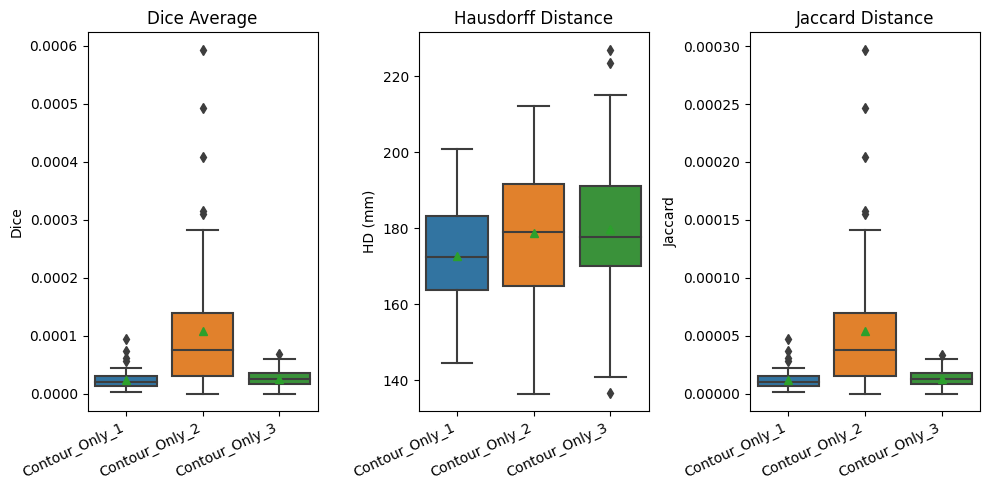

Dice
Contour_Only_1 0.000 +- 0.000
Contour_Only_2 0.000 +- 0.000
Contour_Only_3 0.000 +- 0.000

Hausdorff
Contour_Only_1 172.764 +- 13.571
Contour_Only_2 178.799 +- 17.486
Contour_Only_3 179.871 +- 18.916

Jaccard
Contour_Only_1 0.000 +- 0.000
Contour_Only_2 0.000 +- 0.000
Contour_Only_3 0.000 +- 0.000



In [18]:
import matplotlib.ticker as mticker

results['Dice Average'] = results[['Dice Lungs', 'Dice Heart']].mean(axis=1)
results['HD Average'] = results[['HD Lungs', 'HD Heart']].mean(axis=1)
results['Jaccard Average'] = results[['Jaccard Lungs', 'Jaccard Heart']].mean(axis=1)

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,3,1)
sns.boxplot(x = 'Model', y = 'Dice Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice Average')
plt.xlabel(None)

ax = plt.subplot(1,3,2)
sns.boxplot(x = 'Model', y = 'HD Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

ax = plt.subplot(1,3,3)
sns.boxplot(x = 'Model', y = 'Jaccard Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Jaccard')
plt.title('Jaccard Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num3.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Average'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Average'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Average'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Average'][results['Model'] == model]))

print('')

print('Jaccard')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Jaccard Average'][results['Model'] == model]), '+- %.3f' % np.std(results['Jaccard Average'][results['Model'] == model]))

print('')

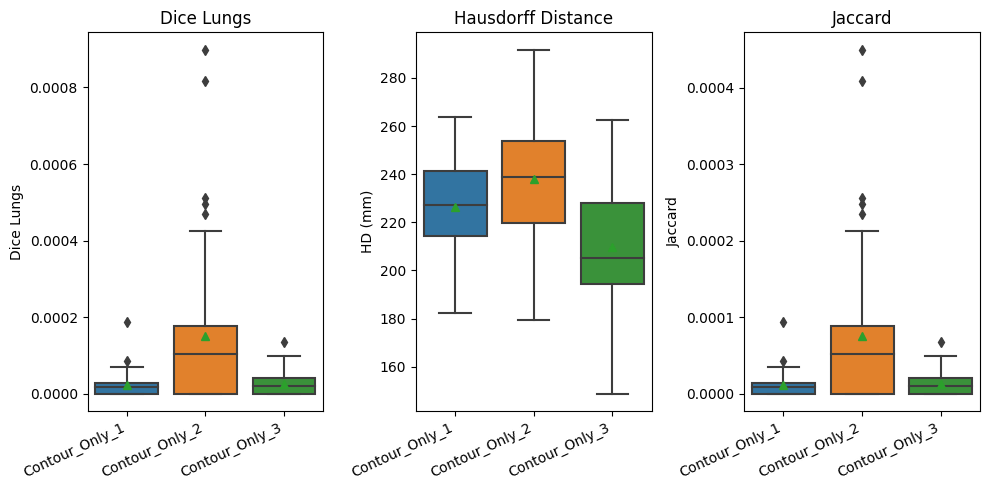

Dice
Contour_Only_1 0.0000 +- 0.0000
Contour_Only_2 0.0002 +- 0.0002
Contour_Only_3 0.0000 +- 0.0000

Hausdorff
Contour_Only_1 226.3371 +- 19.8750
Contour_Only_2 237.9211 +- 26.3810
Contour_Only_3 209.9425 +- 24.9788

Jaccard
Contour_Only_1 0.0000 +- 0.0000
Contour_Only_2 0.0001 +- 0.0001
Contour_Only_3 0.0000 +- 0.0000



In [19]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,3,1)
sns.boxplot(x = 'Model', y = 'Dice Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Lungs')
plt.title('Dice Lungs')
plt.xlabel(None)

ax = plt.subplot(1,3,2)
sns.boxplot(x = 'Model', y = 'HD Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

ax = plt.subplot(1,3,3)
sns.boxplot(x = 'Model', y = 'Jaccard Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Jaccard')
plt.title('Jaccard')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num2.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.4f'%np.mean(results['Dice Lungs'][results['Model'] == model]), '+- %.4f' % np.std(results['Dice Lungs'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.4f'%np.mean(results['HD Lungs'][results['Model'] == model]), '+- %.4f' % np.std(results['HD Lungs'][results['Model'] == model]))

print('')

print('Jaccard')
for model in model_names:
    print(model, '%.4f'%np.mean(results['Jaccard Lungs'][results['Model'] == model]), '+- %.4f' % np.std(results['Jaccard Lungs'][results['Model'] == model]))

print('')

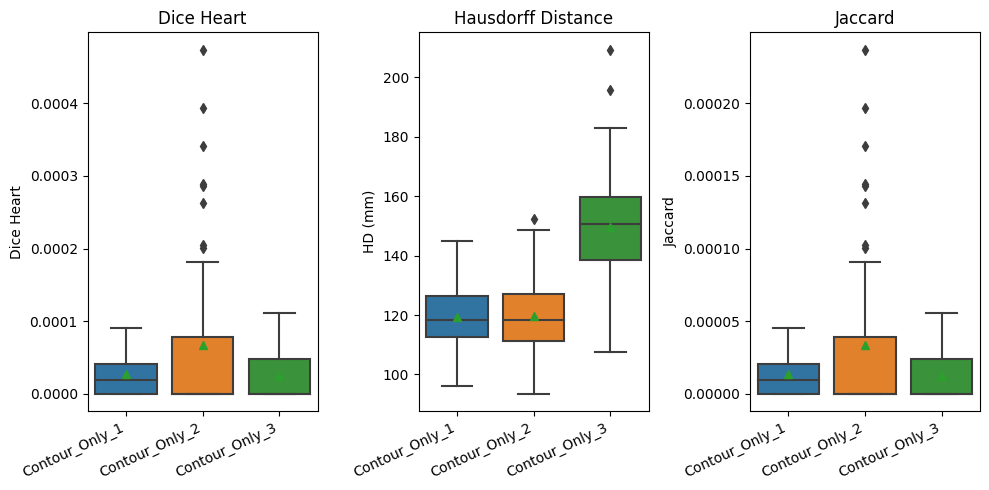

Dice
Contour_Only_1 0.0000 +- 0.0000
Contour_Only_2 0.0001 +- 0.0001
Contour_Only_3 0.0000 +- 0.0000

Hausdorff
Contour_Only_1 119.1908 +- 11.4391
Contour_Only_2 119.6763 +- 12.5944
Contour_Only_3 149.7999 +- 18.1473

Jaccard
Contour_Only_1 0.0000 +- 0.0000
Contour_Only_2 0.0000 +- 0.0001
Contour_Only_3 0.0000 +- 0.0000


In [20]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,3,1)
sns.boxplot(x = 'Model', y = 'Dice Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Heart')
plt.title('Dice Heart')
plt.xlabel(None)

ax = plt.subplot(1,3,2)
sns.boxplot(x = 'Model', y = 'HD Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

ax = plt.subplot(1,3,3)
sns.boxplot(x = 'Model', y = 'Jaccard Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Jaccard')
plt.title('Jaccard')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num1.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.4f'%np.mean(results['Dice Heart'][results['Model'] == model]), '+- %.4f' % np.std(results['Dice Heart'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.4f'%np.mean(results['HD Heart'][results['Model'] == model]), '+- %.4f' % np.std(results['HD Heart'][results['Model'] == model]))

print('')

print('Jaccard')
for model in model_names:
    print(model, '%.4f'%np.mean(results['Jaccard Heart'][results['Model'] == model]), '+- %.4f' % np.std(results['Jaccard Heart'][results['Model'] == model]))
